# CDSDS 542 Sp2026 - Discussion 13: Using Pre-trained Model

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DL4DS/fa2026_discussions/blob/main/discussion_13.ipynb)

# 1. ControlNet
![image](https://raw.githubusercontent.com/lllyasviel/ControlNet/main/github_page/he.png)

ControlNet is a method for adding **conditional structural control** to text-to-image diffusion models such as Stable Diffusion. It enables you to guide generation with inputs like Canny edges, depth maps, segmentation maps, or human poses.


ControlNet trains an additional network that learns to interpret a conditioning input (e.g., an edge map) while preserving the original diffusion model's capabilities.

**Architecture Components for Stable Diffusion - ControlNet:**

* **Frozen copy** of the original diffusion model → protects pretrained knowledge.
* **Trainable copy** of the U-Net encoder → learns how to use conditional input.
* **Zero Convolutions** connecting the two copies → start as zeros; gradually learn residual corrections.

![image](https://raw.githubusercontent.com/lllyasviel/ControlNet/main/github_page/sd.png)




# 2. Example

Using: https://github.com/lllyasviel/ControlNet/tree/main

In [1]:
# modules
!pip install diffusers transformers accelerate controlnet_aux opencv-python -q

import cv2
import numpy as np
import matplotlib.pyplot as plt

import requests
from io import BytesIO
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 15.8 MB/s eta 0:00:00


**Edge**

(np.float64(-0.5), np.float64(218.5), np.float64(230.5), np.float64(-0.5))

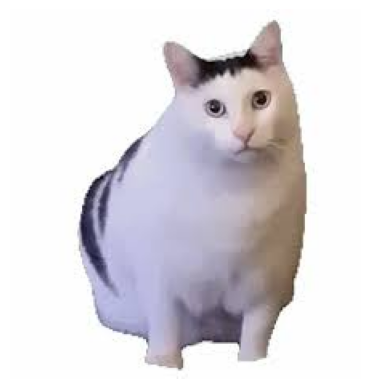

In [57]:
response = requests.get("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQJ_DCgCwy0fddxnCLvoBaGifVwKKmq28hKJw&s")
input_image = Image.open(BytesIO(response.content)).convert("RGB")
plt.imshow(input_image, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

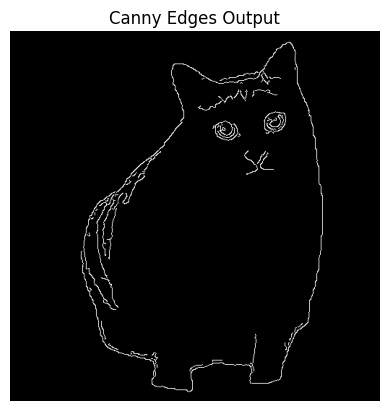

In [58]:
from controlnet_aux import CannyDetector

canny_detector = CannyDetector()
edges = canny_detector(input_image).convert("RGB")

plt.title("Canny Edges Output")
plt.imshow(edges, cmap='gray')
plt.axis('off')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

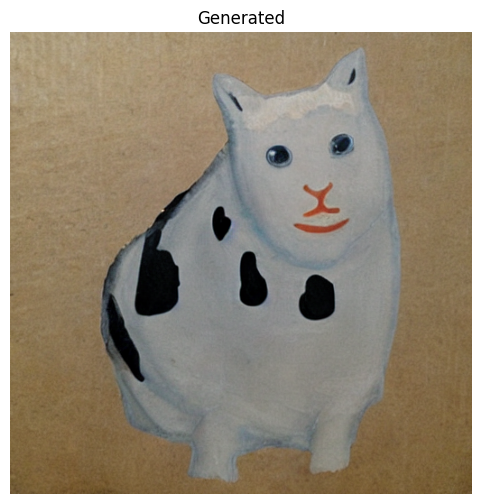

In [63]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

edges_PIL = edges.convert("RGB")

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
         "runwayml/stable-diffusion-v1-5",
         controlnet=controlnet,
         torch_dtype=torch.float16
       ).to("cuda")
prompt = "a carton cow cat"


result = pipe(prompt, image=edges_PIL, num_inference_steps=500)
gen = result.images[0]

plt.figure(figsize=(6,6))
plt.imshow(gen)
plt.axis("off")
plt.title("Generated")
plt.show()

**Depth map**

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


(np.float64(-0.5), np.float64(511.5), np.float64(703.5), np.float64(-0.5))

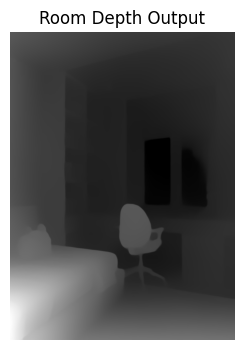

In [30]:
from controlnet_aux import MidasDetector

response = requests.get("https://raw.githubusercontent.com/lllyasviel/ControlNet/main/test_imgs/room.png")
room_image = Image.open(BytesIO(response.content)).convert("RGB")

midas = MidasDetector.from_pretrained("lllyasviel/Annotators")
depth = midas(room_image)

plt.title("Room Depth Output")
plt.imshow(depth)
plt.axis('off')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

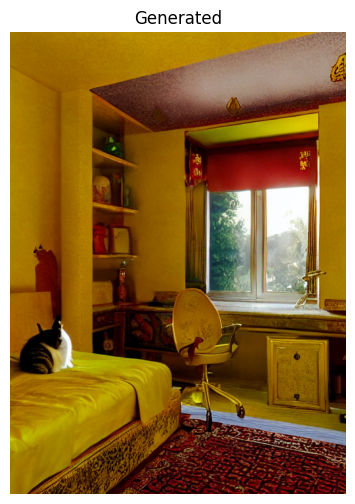

In [37]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
         "runwayml/stable-diffusion-v1-5",
         controlnet=controlnet,
         torch_dtype=torch.float16
       ).to("cuda")
prompt = "a golden chinese-style room, with a cat on the bed, sunny outside the window"

result = pipe(prompt, image=depth, num_inference_steps=200)
gen = result.images[0]

plt.imshow(gen)
plt.axis("off")
plt.title("Generated")
plt.show()

**Human Pose**

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

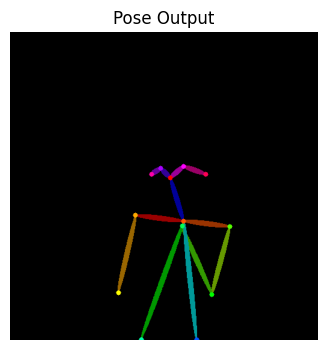

In [50]:
from controlnet_aux import OpenposeDetector

response = requests.get("https://scontent-bos5-1.cdninstagram.com/v/t51.2885-19/307848328_448645750571208_2939090749819440312_n.jpg?stp=dst-jpg_s150x150_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6InByb2ZpbGVfcGljLmRqYW5nby4xMDgwLmMyIn0&_nc_ht=scontent-bos5-1.cdninstagram.com&_nc_cat=100&_nc_oc=Q6cZ2QHAsz8M_nHLaRENYwLqhNQjUXmJ82xf7eVKjjV9YTsvIgwljtRu_bp84OHKVSCvMNmbwOwEFsTXNBb8eyJ63Gyb&_nc_ohc=O7M6EngUM_oQ7kNvwHnEwXi&_nc_gid=K4l84A33SDfXs5d-plNl-A&edm=AP4sbd4BAAAA&ccb=7-5&oh=00_AfkOv1oGufuENj7-Xw0t1S1pBsawR3-Pf1iZ3SwppGVBIg&oe=6935786B&_nc_sid=7a9f4b")
pose_image = Image.open(BytesIO(response.content)).convert("RGB")

pose_detector = OpenposeDetector.from_pretrained("lllyasviel/Annotators")
pose = pose_detector(pose_image)

plt.figure(figsize=(8,4))
plt.title("Pose Output")
plt.imshow(pose)
plt.axis('off')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

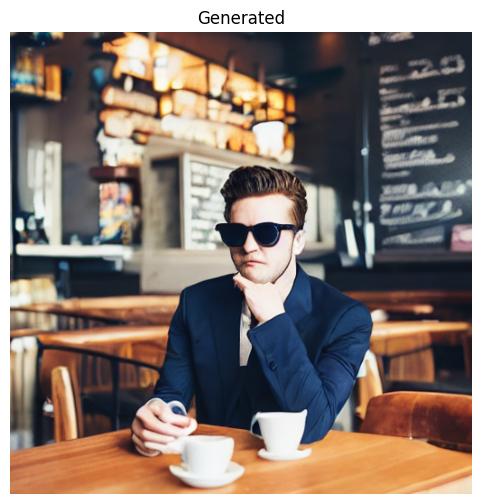

In [52]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
         "runwayml/stable-diffusion-v1-5",
         controlnet=controlnet,
         torch_dtype=torch.float16
       ).to("cuda")
prompt = "a man in suit wearing sunglasses sitting in a cafe"

result = pipe(prompt, image=pose, num_inference_steps=500)
gen = result.images[0]

plt.figure(figsize=(6,6))
plt.imshow(gen)
plt.axis("off")
plt.title("Generated")
plt.show()

# 3. Exercise
![image](https://i.redd.it/xvv422i01zcd1.png)

### TODO:
   **Take a photo of someone in our class, and use your own prompt to generate an image that matches their pose, edges, or any features you want to preserve! (You may choose any models you would like for the condition. Besides, you are also free to experiment with different diffusion models if you prefer.)**



In [3]:
# example for detectors that you can use
print([name for name in dir(controlnet_aux) if "Detector" in name])

['AnylineDetector', 'CannyDetector', 'ContentShuffleDetector', 'DWposeDetector', 'LeresDetector', 'LineartAnimeDetector', 'LineartDetector', 'LineartStandardDetector', 'MediapipeFaceDetector', 'MidasDetector', 'NormalBaeDetector', 'OpenposeDetector', 'PidiNetDetector', 'SamDetector', 'ZoeDetector']


In [ ]:
# TODO: define the detector
from controlnet_aux import 👆
my_detector =

In [ ]:
# TODO: load the image that you choose
my_image =
my_image

In [ ]:
# TODO: get the preserved feature
my_feature_img = my_detector(my_image)
my_feature_img

In [ ]:
# TODO: complete the pipeline
controlnet =
pipe =
prompt =

result =
gen = result.images[0]

plt.imshow(gen)
plt.axis("off")
plt.title("Generated")
plt.show()

Reference:
- https://github.com/lllyasviel/ControlNet/discussions/188
- https://github.com/lllyasviel/ControlNet/tree/main
- https://dl4ds.github.io/fa2025/static_files/lectures/24_pretrained.pdf